In [1]:
# Released under MIT License
#
# Copyright (c) 2023 Andrew SID Lang, Oral Roberts University, U.S.A.
#
# Copyright (c) 2023 Jan HR Woerner, Oral Roberts University, U.S.A.
#
# Copyright (c) 2023 Wei-Khiong (Wyatt) Chong, Advent Polytech Co., Ltd, Taiwan.
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
# documentation files (the "Software"), to deal in the Software without restriction, including without limitation the
# rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to
# permit persons to whom the Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the
# Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO
# THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS
# OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR
# OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

import torch
from torch.utils.data import Dataset
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
import pandas as pd
import warnings
warnings.filterwarnings("ignore", message="Was asked to gather along dimension 0, but all input tensors were scalars")

In [2]:
class MyData:
    def __init__(self, i_data):
        self.data = i_data
        
    def get_split(self, train_ratio=0.8, valid_ratio=0.1, seed=None):
        n = len(self.data)
        indices = np.arange(n)
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(indices)
        train_size = int(train_ratio * n)
        valid_size = int(valid_ratio * n)
        train_indices = indices[:train_size]
        valid_indices = indices[train_size:train_size+valid_size]
        test_indices = indices[train_size+valid_size:]
        i_train_data = self.data.iloc[train_indices].reset_index(drop=True)
        i_valid_data = self.data.iloc[valid_indices].reset_index(drop=True)
        i_test_data = self.data.iloc[test_indices].reset_index(drop=True)
        return i_train_data, i_valid_data, i_test_data

In [3]:
class Input(Dataset):
    def __init__(self, i_data, i_tokenizer, i_max_length):
        self.data = i_data
        self.tokenizer = i_tokenizer
        self.max_length = i_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        smiles = self.data.iloc[idx]["Standardized_SMILES"]
        inputs = self.tokenizer(smiles, return_tensors="pt", padding='max_length', truncation=True, max_length=self.max_length)
        inputs["input_ids"] = inputs["input_ids"].squeeze(0)
        inputs["attention_mask"] = inputs["attention_mask"].squeeze(0)
        if "token_type_ids" in inputs:
            inputs["token_type_ids"] = inputs["token_type_ids"].squeeze(0)
        inputs["labels"] = torch.tensor(self.data.iloc[idx]["median_WS"], dtype=torch.float).unsqueeze(0)
        return inputs

In [4]:
# Read in solubility data
my_data = pd.read_csv('aqua.csv')

# Create an instance of the MyData class
my_data = MyData(my_data)

# Split your data into training, validation, and testing sets
train_data, valid_data, test_data = my_data.get_split(seed = 123)

# pick out columns
data = train_data[['Standardized_SMILES', 'median_WS']]
valid = valid_data[['Standardized_SMILES', 'median_WS']]
test = test_data[['Standardized_SMILES', 'median_WS']]

In [5]:
#AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

# Load a pretrained transformer model and tokenizer
model_name = "DeepChem/ChemBERTa-77M-MTR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)
config.num_hidden_layers += 1
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

#see if GPU
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
# move model to the device
model.to(device) 

Some weights of the model checkpoint at DeepChem/ChemBERTa-77M-MTR were not used when initializing RobertaForSequenceClassification: ['regression.dense.weight', 'regression.out_proj.weight', 'regression.out_proj.bias', 'norm_mean', 'norm_std', 'regression.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weigh

Using GPU.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
             

In [6]:
from transformers import TrainerCallback
import numpy as np
import evaluate

# Define the maximum sequence length
max_length = 195

# Prepare the dataset for training
train_dataset = Input(data, tokenizer, max_length)
validation_dataset = Input(valid, tokenizer, max_length)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./output",
    optim="adamw_torch", # switch optimizer to avoid warning
    num_train_epochs=100,  # Train the model for 100 epochs
    per_device_train_batch_size=128,  # Set the batch size to 128
    per_device_eval_batch_size=128,  # Set the evaluation batch size to 128
    logging_steps=10,  # Log training metrics every 100 steps
    eval_steps=10,  # Evaluate the model every 100 steps
    save_steps=10,  # Save the model every 100 steps
    seed=123,  # Set the random seed for reproducibility
    evaluation_strategy="steps",  # Evaluate the model every eval_steps steps
    load_best_model_at_end=True
)

# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)


# Define a callback for printing validation loss
class PrintValidationLossCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, **kwargs):
        if state is not None and hasattr(state, 'eval_loss'):
            print(f"Validation loss: {state.eval_loss:.4f}")

# Add the callback to the trainer
trainer.add_callback(PrintValidationLossCallback())



metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Train the model
trainer.train()

# Save the model
trainer.save_model("./output")

Step,Training Loss,Validation Loss
10,14.498500,13.903141
20,13.312500,12.314187
30,11.331700,9.889343
40,8.833300,6.695904
50,5.992700,4.188548
60,4.179500,3.679473
70,3.394800,2.733828
80,2.690900,2.194749
90,2.184800,1.792031
100,1.916600,1.556690


In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from transformers import pipeline

# Create a prediction pipeline
predictor = pipeline("text-classification", model=model, tokenizer=tokenizer)

TRAINING SET
N: 8165
R2: 0.8702982901268843
Root Mean Square Error: 0.8173305996108375
Mean Absolute Error: 0.5987025186064614
Spearman correlation: 0.930919173416945
p-value: 0.0


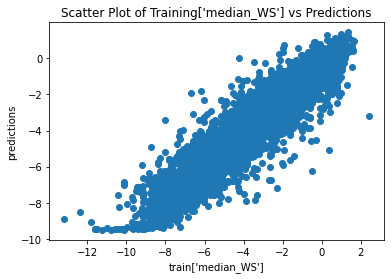

In [8]:
# Prepare new SMILES strings for prediction
train_smiles = data['Standardized_SMILES']

# Predict properties for new SMILES strings
predictions = []
for smiles in train_smiles:
    inputs = tokenizer(smiles, return_tensors="pt", padding='max_length', truncation=True, max_length=195).to(device) #max_length=195
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_property = outputs.logits.squeeze().item()
    predictions.append(predicted_property)

r_mse = mean_squared_error(data["median_WS"], predictions, squared=False)
r2 = r2_score(data["median_WS"], predictions)
mae = mean_absolute_error(data["median_WS"], predictions)

print("TRAINING SET")
print("N:", len(data["median_WS"]))
print("R2:", r2)
print("Root Mean Square Error:", r_mse)
print("Mean Absolute Error:", mae)

# assume test and predictions are two arrays of the same length
correlation, p_value = spearmanr(data["median_WS"], predictions)

print("Spearman correlation:", correlation)
print("p-value:", p_value)

plt.scatter(data["median_WS"], predictions)
plt.xlabel("train['median_WS']")
plt.ylabel("predictions")
plt.title("Scatter Plot of Training['median_WS'] vs Predictions")
plt.show()

VALIDATION SET
N: 1020
R2: 0.8346196871525771
Root Mean Square Error: 0.9301778088403094
Mean Absolute Error: 0.6894259539831057
Spearman correlation: 0.9164363654548762
p-value: 0.0


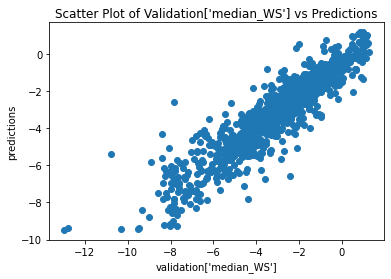

In [9]:
# Prepare new SMILES strings for prediction
valid_smiles = valid['Standardized_SMILES']

# Predict properties for new SMILES strings
predictions = []
for smiles in valid_smiles:
    inputs = tokenizer(smiles, return_tensors="pt", padding='max_length', truncation=True, max_length=195).to(device) #max_length=195
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_property = outputs.logits.squeeze().item()
    predictions.append(predicted_property)

r_mse = mean_squared_error(valid["median_WS"], predictions, squared=False)
r2 = r2_score(valid["median_WS"], predictions)
mae = mean_absolute_error(valid["median_WS"], predictions)

print("VALIDATION SET")
print("N:", len(valid["median_WS"]))
print("R2:", r2)
print("Root Mean Square Error:", r_mse)
print("Mean Absolute Error:", mae)

# assume test and predictions are two arrays of the same length
correlation, p_value = spearmanr(valid["median_WS"], predictions)

print("Spearman correlation:", correlation)
print("p-value:", p_value)

plt.scatter(valid["median_WS"], predictions)
plt.xlabel("validation['median_WS']")
plt.ylabel("predictions")
plt.title("Scatter Plot of Validation['median_WS'] vs Predictions")
plt.show()

TEST SET
N: 1022
R2: 0.8223617048517198
Root Mean Square Error: 0.9380008871807847
Mean Absolute Error: 0.6807156079688436
Spearman correlation: 0.8991562895604099
p-value: 0.0


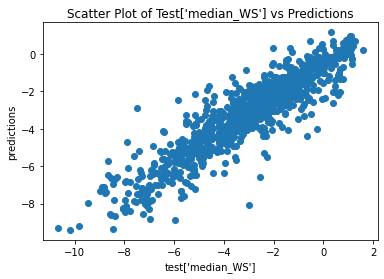

In [10]:
# Prepare new SMILES strings for prediction
test_smiles = test['Standardized_SMILES']

# Predict properties for new SMILES strings
predictions = []
for smiles in test_smiles:
    inputs = tokenizer(smiles, return_tensors="pt", padding='max_length', truncation=True, max_length=195).to(device) #max_length=195
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_property = outputs.logits.squeeze().item()
    predictions.append(predicted_property)

r_mse = mean_squared_error(test["median_WS"], predictions, squared=False)
r2 = r2_score(test["median_WS"], predictions)
mae = mean_absolute_error(test["median_WS"], predictions)

print("TEST SET")
print("N:", len(test["median_WS"]))
print("R2:", r2)
print("Root Mean Square Error:", r_mse)
print("Mean Absolute Error:", mae)

# assume test and predictions are two arrays of the same length
correlation, p_value = spearmanr(test["median_WS"], predictions)

print("Spearman correlation:", correlation)
print("p-value:", p_value)

plt.scatter(test["median_WS"], predictions)
plt.xlabel("test['median_WS']")
plt.ylabel("predictions")
plt.title("Scatter Plot of Test['median_WS'] vs Predictions")
plt.show()

In [12]:
# Save results
results_df = pd.DataFrame({"actual_WS": test["median_WS"], "predicted_WS": predictions})
results_df.to_csv("testset_results.csv", index=False)